# Home Credit Default Risk

참고 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/notebook

# Introduce

## Data

고객이 대출금을 상환할 것인지 혹은 어려움을 겪을 것인지 예측하는 것은 중요한 사항이다. 다음과 같은 7가지 데이터소스가 있다.
- application_train/test : Home Credit의 대출 신청자에 대한 정보가 포함된 train, test 데이터. 모든 대출은 행이 있고 SK_ID_CURR 변수로 식별된다. 신청자의 train 데이터는 0(대출금 상환됨)과 1(대출금이 상환되지 않음)을 나타내는 TARGET이 있다.
- bureau : 고객의 다른 금융 기관의 이전 신용도 데이터. 각 이전 신용은 하나의 행이 있지만, 하나의 신청 데이터의 한 대출에 대해선 여러 개의 이전 신용 데이터가 있을 수 있다.
- bureau_balance : bureau의 이전 신용에 대한 월별 데이터. 각 행은 한 달간의 이전 신용이고, 하나의 이전 신용은 신용 기간에 따라 (월별) 여러 행을 가질 수 있다.
- previous_application : 신청 데이터에 대출이 있는 고객이 Home Credit에서 이전에 대출을 신청한 데이터. 신청 데이터의 각 현재 대출금엔 여러 개의 이전 대출금이 있을 수 있다. 각 이전 신청은 한 행을 가지며 SK_ID_PREV 변수에 의해 식별된다.
- POS_CASH_BALANCE : 이전 판매 시점이나 고객이 Home Credit에서 이전에 현금 대출한 시점에 대한 월별 데이터. 각 행은 이전의 판매나 현금 대출 시점에 대한 한 달이며, 각 이전 대출은 여러 행을 가질 수 있다.
- creadit_card_balance : 고객이 Home Credit에서 가지고 있던 이전 신용카드에 대한 월별 데이터. 각 행은 한 달간의 신용카드 잔액이고, 각 신용카드는 여러 행을 가질 수 있다.
- installments_payment : Home Credit에서 이전 대출금 결제 내역. 모든 결제된 건에 대해 한 행이 있고, 누락된 결제 건에 대해 한 행이 있다.

모든 데이터와 열에 대한 정의는 HomeCredit_columns_description.csv를 참고. 여기선 주요 train, test 데이터의 주요 신청만 사용한다. 

## Metric: ROC AUC

일단 데이터를 파악하면 제출시 점수가 판단되는 지표를 이해해야한다. 이 경우, ROC, AUC (Receiver Operating Characteristic Area Under the Curve, AUROC라고도 함)로 알려진 분류 지표다.<br><br>
ROC AUC는 두 가지 개별적인 개념을 이해할 수 있으면 비교적 간단하다. ROC 곡선은 true positive 비율과 false positive 비율을 그래프로 나타낸다.<br><br>
그래프의 선은 단일 모델의 곡선을 나타내고, 선의 움직임은 positive 인스턴스를 분류하는 데 사용되는 임계값이 변경되는 것을 나타낸다. 임계값은 우측 상단의 0으로 시작하고 좌측 하단의 1로 향한다. 좌측과 상단에 있을수록 더 좋은 모델이다. <br><br>
AUC(Area Under the Curve)는 그 이름에서 알 수 있듯 ROC 곡선 아래의 영역(곡선의 적분)이다. 0과 1 사이의 지표이며 더 나은 모델일수록 점수가 높다. 랜덤으로 단순 추측하는 모델은 ROC AUC가 0.5다.<br><br>
ROC AUC에 따라 분류기를 평가할 때, 0과 1 예측을 생성하는 것이 아니라 0과 1 사이 확률을 생성하는 것이다. 보통 정확도로 평가하는 것을 생각하지만, target이 불균형한 데이터에서 정확도는 최고의 지표가 아니다. (예시로, 100명 중 1명이 범인이면 모두 범인이 아니라고 하는 게 정확도가 99%임) ROC AUC가 모델 성능을 더 잘 나타낸다. 

# Read in Data

## Imports

In [1]:
# 데이터 조작
import numpy as np
import pandas as pd
# 범주형 변수 처리 
from sklearn.preprocessing import LabelEncoder
# 파일 시스템 관리
import os
# warnings 방지
import warnings
warnings.filterwarnings('ignore')
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data

In [2]:
# 사용가능한 파일 나열
print(os.listdir('../input/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# train 데이터
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape:', app_train.shape)
app_train.head()

Training data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


train 데이터는 307511개의 관측치와 TRAGET을 포함한 122개의 변수가 있다.

In [4]:
# test 데이터 변수
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape:', app_test.shape)
app_test.head()

Testing data shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


test 데이터셋이 크기가 더 작고 TARGET 열이 없다.

# Exploratory Data Analysis

EDA(Exploratory DAta Analysis)는 통계량을 계산하고 수치를 만들어 데이터의 추세, 이상징후, 패턴, 관계를 찾는 개방형 프로세스다. EDA의 목표는 데이터가 우리에게 말해줄 수 있는 걸 배우는 것이다. 일반적으로 높은 수준의 개요로 시작해 특정 영역으로 좁혀진다. 연구 결과는 그 자체로 흥미로울 수도 있고, 어떤 변수를 사용할지 결정할 수 있도록 도우며 모델 선택에 사용될 수 있다.

## Examine the Distribution of the Target Column

target은 예측해야할 것이다. 0은 제시기에 대출금이 상환되었다는 것을, 1은 고객이 대출금 지불에 어려움을 겪은 것을 나타낸다. 우선 각 범주에 속하는 대출 건수를 알아보자.

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

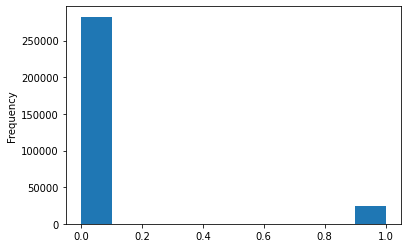

In [6]:
app_train['TARGET'].astype(int).plot.hist()

불균형 문제가 있다는 것을 알 수 있다. 상환되지 않은 대출금보다 상환된 대출금이 훨씬 많다. 더 정교한 기계학습 모델을 위해선 클래스(0,1)에 가중치를 부여해 불균형 문제를 해결할 수 있다.

## Examine missing values

각 열에서 결측값의 수와 비율을 알아보자.

In [15]:
# 열의 결측값을 계산하는 함수
def missing_values_table(df):
    mis_val = df.isnull().sum()  # 총 결측값 수
    mis_val_percent = 100*df.isnull().sum() / len(df)  # 결측값 비율
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  # 결과 테이블
    
    mis_val_table_ren_columns = mis_val_table.rename(      # 테이블 열 이름 변경
    columns = {0:'Missing Values', 1:'% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[      # 결측비율로 테이블
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(  # 내림차순 정렬
    '% of Total Values', ascending=False).round(1)
    
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'  # 요약
            'There are ' + str(mis_val_table_ren_columns.shape[0]) + ' columns that have missing values.')
    
    return mis_val_table_ren_columns  # 결측값 정보 데이터프레임 반환

In [16]:
# 결측값 통계량
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


기계학습 모델을 구축하려면 이러한 결측값을 대체해야한다(imputation이라고 함). 이후에, imputation 하지 않고 결측값을 처리할 수 있는 XGBoost와 같은 모델을 사용할 것이다. 결측값 비율이 높은 열을 삭제하는 방법도 있는데, 그 열이 모델에 유용할지 미리 알 수 없다. 따라서 일단 모든 열을 유지한다.

## Column Types

각 데이터타입의 열 수를 보자. int64와 float64는 (이산 혹은 연속형) 숫자 변수다. object 열은 문자열을 포함한 범주형 변수다.

In [17]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

각 object (범주형) 열의 고유한 범주 수를 알아보자.

In [21]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

대부분의 범주형 변수는 비교적 고유한 범주 수가 적다. 이런 범주형 변수를 다룰 방법을 찾아야한다.

## Encoding Categorical Variables

범주형 변수를 처리해야한다. 기계학습 모델은 범주형 변수를 처리할 수 없다(LightGBM과 같은 모델 제외). 따라서 이런 변수를 모델에 입력하기 전에 숫자로 인코딩하는 방법을 사용하는데, 다음과 같은 두 가지 방법이 있다.

- Label encoding : 범주형 변수의 각 고유한 범주를 정수로 할당해 새로운 열은 생성되지 않는다.
- One-hot encoding : 범주형 변수의 각 고유한 범주에 대해 새로운 열을 생성한다. 각 관측치는 해당 범주에 대한 열은 1로, 다른 모든 열은 0으로 표현된다.

label encoding의 문제는 범주에 임의적인 순서를 부여한다는 것이다. 각 범주에 할당된 정수값은 랜덤하고 범주의 고유한 측면을 반영하지 않는다. a=1, b=4로 label encoding을 하고 같은 과정을 반복하면 값이 달라질 수 있다. 범주형 변수의 고유한 범주가 두 개만 있다면(예: 성별) label encoding도 괜찮지만, 두 개 이상이면 one-hot encoding이 안전하다.

일부 모델은 label encoding된 범주형 변수를 문제 없이 처리할 수 있다. one-hot encoding의 단점은 범주 수가 많으면 변수의 수가 폭발적으로 증가할 수 있다는 것이다. 이걸 처리하기 위해 PCA나 다른 차원 축소 방법을 사용한 후 one-hot encoding을 적용해 차원 수를 축소할 수 있다.

여기선 범주가 2개인 범주형 변수에 대해 label encoding을 하고 범주가 2개 이상이면 one-hot encoding을 사용한다. (차원축소 또한 사용하지 않는다.)

### Label Encoding and One-hot Encoding

label encoding은 scikit-learn의 LabelEncoder를, one-hot encoding은 pandas의 get_dummies(df) 함수를 사용한다.

In [23]:
le = LabelEncoder()  # label encoder 객체 생성
le_count = 0

for col in app_train :  # 열 반복
    if app_train[col].dtype == 'object' :
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])  # train데이터 학습
            
            app_train[col] = le.transform(app_train[col])  # train데이터 변환
            app_test[col] = le.transform(app_test[col])  # test데이터 변환
            
            le_count += 1  # label encoding된 열의 수
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [24]:
# 범주형 변수 one-hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape :', app_train.shape)
print('Testing Features shape :', app_test.shape)

Training Features shape : (307511, 243)
Testing Features shape : (48744, 239)


### Aligning Training and Testing Data

train, test 데이터에 모두 같은 변수가 있어야한다. one-hot encoding은 test 데이터에 범주가 표시되지 않는 일부 범주형 변수가 있어 train 데이터가 더 많은 열을 생성했다. test 데이터에 없는 train 데이터의 열을 제거하려면 데이터프레임을 정렬해야한다. 먼저 train 데이터에서 target 열을 추출한다. 정렬할 땐 행이 아닌 열 기준으로 데이터프레임을 정렬하도록 axis=1로 설정해야한다.

In [26]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join='inner', axis=1)  # 둘다 있는 열만 유지하며 정렬
app_train['TARGET'] = train_labels  # target 다시 추가 (위 작업에서 target 빠짐)

print('Training Features shape :', app_train.shape)
print('Testing Features shape :', app_test.shape)

Training Features shape : (307511, 240)
Testing Features shape : (48744, 239)


이제 train, test 데이터셋은 기계학습에 필요한 같은 변수를 갖는다. one-hot encoding으로 인해 변수의 수가 상당히 많아졌다. 어느 시점에 데이터셋의 크기를 줄이기 위해 차원축소(관련 없는 변수 제거)를 시도할 수도 있다.

## Back to EDA

### Anomalies (이상치)

EDA를 진행할 때 데이터의 이상치를 주의해야한다. 잘못 입력된 숫자, 측정 장비 오류, 극단적 측정 때문일 수 있다. 이상치는 describe 메소드를 사용해 열의 통계량으로 볼 수 있다. DAYS_BIRTH 열의 숫자는 현재 대출 신청과 관련된 기록이므로 음수다. 연도별 통계를 보려면 -1을 곱하고 1년의 날짜 수(365)로 나눈다.

In [27]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

나이대가 적당해보인다. 최대값과 최소값에서 나이의 이상치가 없다. 입사일도 살펴보자.

In [30]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

올바르지 않아보인다. 최대값은 약 1000년이다.

Text(0.5, 0, 'Days Employment')

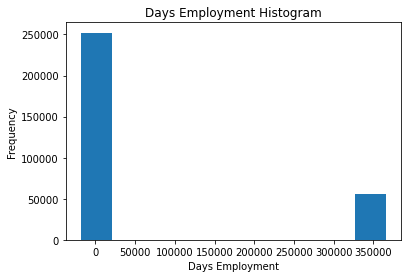

In [31]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

이상치인 고객을 세분화해서 다른 고객보다 채무불이행률이 더 높은지 낮은지 알아보자.

In [32]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]  ### 최대값(이상치)
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]  ### 이상치 아닌 값

print('The non-anomalies default on %0.2f%% of loans' % (100*non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100*anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


이상치의 기본값이 더 낮다.

이상치를 처리하는 것은 정확한 상황에 따라 달라진다. 가장 안전한 방법 중 하나는 기계학습 전에 이상치를 결측값으로 설정하고 (imputation을 통해) 채우는 것이다. 이 경우, 모든 이상치가 같은 값을 가지므로 모든 대출금이 공통점을 가지면 같은 값으로 채우고 싶을 것이다. 이상치는 어느 정도 중요해보이므로 이 값을 실제로 채웠는지 기계학습 모델에 알리고 싶다. 해결방법으로 이상치를 숫자가 아닌 값(np.nan)으로 채우고 값이 이상치인지 나타내는 새로운 boolean 열을 생성한다.

Text(0.5, 0, 'Days Employment')

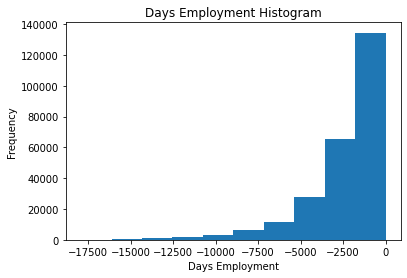

In [34]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243  # 이상치 표시하는 열 생성
app_train['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)  # 이상치를 nan으로 대체

app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

분포가 예상보다 훨씬 일치하는 것으로 보이고 이 값들이 원래 이상치였다는 것을 모델에 알리는 열을 새로 생성했다(nan을 어떤 값, 아마 중위수로 채워야하기 때문). 데이터프레임의 DAYS가 있는 다른 열은 명확한 이상치가 없을 것으로 예상하는 열을 나타낸다.

train 데이터에 한 모든 작업은 test 데이터에도 해야한다. 

In [35]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

print('There are %d anomalies in the test data out of %d entries' % (app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

범주형 변수와 이상치를 다루었으므로 EDA를 계속해보자. 데이터를 이해하는 방법 중 하나는 변수와 target간 상관관계를 찾는 것이다. 데이터프레임 메소드 .corr 를 사용해 모든 변수와 target간 Pearson 상관계수를 계산할 수 있다.

상관계수는 변수의 "관련성"를 나타내는 가장 좋은 방법은 아니지만, 데이터에서 가능한 관계에 대한 아이디어를 제공한다. 상관계수 절대값에 대한 일반적인 해석은 다음과 같다.
- .00-.19 : 매우 약함
- .20-.39 : 약함
- .40-.59 : 중간
- .60-.79 : 강함
- .80-1.0 : 매우 강함

In [38]:
correlations = app_train.corr()['TARGET'].sort_values()  # target과 상관관계를 찾아 정렬

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correltaions:\n', correlations.head(15))

Most Positive Correlations:
 FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
DAYS_EMPLOYED_ANOM                                        NaN
Name: TARGET, dtype: float64

Most Negati

DAYS_BIRTH가 양의 상관관계가 가장 높다. (본인과의 상관관계는 항상 1이므로 TARGET은 제외) DAYS_BIRTH는 대출 시점의 고객의 연령을 일로 표시한 것이다. 상관관계는 양수지만 변수의 값은 실제로 음수이므로, 고객이 나이들수록 대출금의 채무불이행(target==0)이 발생할 가능성이 적다. 헷갈리지 않기 위해 변수에 절대값을 취하면 상관관계가 음수가 될 것이다.

### Effect of Age on Repayment

In [40]:
# 출생 후 일 수(양수)와 target의 상관관계
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

고객이 나이가 많을수록 target과 음의 선형관계를 갖는데, 고객이 나이가 많을수록 대출금을 제때 상환하는 경향이 더 많다는 것을 의미한다.

이제 이 변수를 살펴보자. 우선, 연령의 히스토그램을 볼 수 있다. 이해하기 쉽도록 x축에 연도를 넣는다.

Text(0, 0.5, 'Count')

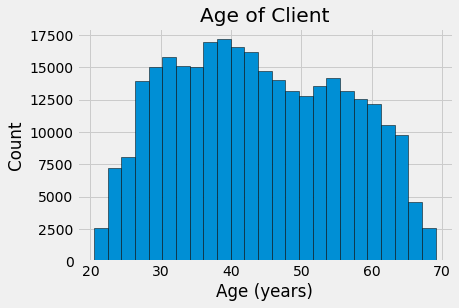

In [41]:
plt.style.use('fivethirtyeight')  # plot style 설정

# 연령 분포 시각화
plt.hist(app_train['DAYS_BIRTH']/365, edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

연령 분포는 이상치가 없다는 것 외에 정보가 거의 없다. 나이가 target에 미치는 영향을 시각화하기 위해, target값으로 색상이 설정된 KDE(커널 밀도 추정) plot을 그린다. KDE는 단일 변수의 분포를 나타내며 smoothed histogram(각 데이터 지점에서 보통 가우시간인 커널을 계산하고, 모든 개별 커널을 평균화해 단일 smooth curve를 개발함)으로 생각할 수 있다. 이 그래프는 seaborn의 kdeplot을 사용한다.

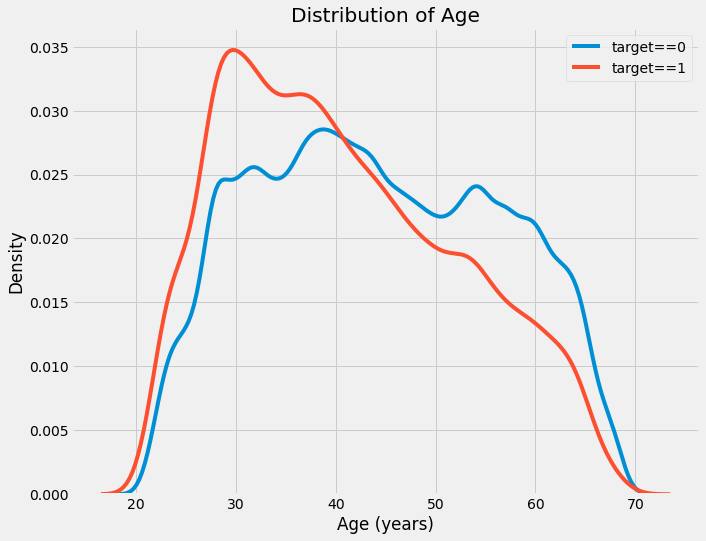

In [43]:
plt.figure(figsize=(10,8))

# 제때 상환된 대출금 KDE plot
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH']/365, label='target==0')
# 제때 상환되지 못한 대출금 KDE plot
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH']/365, label='target==1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Age')
plt.legend()

target==1 곡선은 더 어린 쪽을 향해 기울어진다. 유의한 상관계수는 아니지만(-0.07), 이 변수는 target에 영향을 미치므로 기계학습 모델에 유용할 수 있다. 연령층별 대출금 상환 실패 평균으로 관계를 살펴보자.

그래프를 만들려면 우선, 연령 범주를 각 5년으로 나눈다. 그리고 각 범주에 대해 target값 평균을 계산하는데, 이것은 각 연령 범주에서 상환되지 못한 대출금 비율을 나타낸다.

In [45]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]  # 나이 정보를 개별 데이터프레임으로 저장
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

# 연령 범주화
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20,70,num=11))  ### linspace(a,b,c) : a,b 사이 c-1개로 균등한 간격으로 나눔
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [47]:
# 범주로 그룹화해 target 평균 계산
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

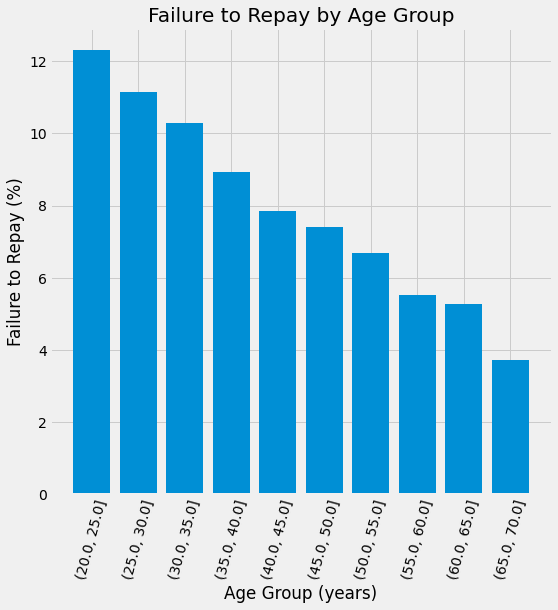

In [48]:
plt.figure(figsize=(8,8))

# 연령 범주와 target 평균의 bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

나이가 어린 신청자일수록 대출금을 상환하지 않는다는 것이 분명히 보인다. 상환불능률은 가장 어린 세 연령그룹에서 10% 이상이고 가장 나이가 많은 그룹에서 5% 미만이다.

젊은 고객이 대출금을 상환할 가능성이 낮으므로 그들에게 안내를 더 많이 하거나 재정 계획 팁을 제공해야한다는 것은 은행에서 사용할 수 있는 정보다. 차별의 의미는 아니지만 젊은 고객이 제때 지불할 수 있도록 예방 조치를 취해야한다.

### Exterior Sources

target과 가장 강한 음의 상관관계를 가진 세 변수는 EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3이다. 이 변수는 "외부 데이터에서 정규화된 점수"를 나타낸다. 정확한 의미는 모르겠지만 아마 수많은 자료를 이용해 만들어진 누적된 신용등급일 것이다.

우선, EXT_SOURCE 변수와 target간 상관관계를 살펴보자.

In [49]:
# EXT_SOURCE 변수 추출 및 상관관계
ext_data = app_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

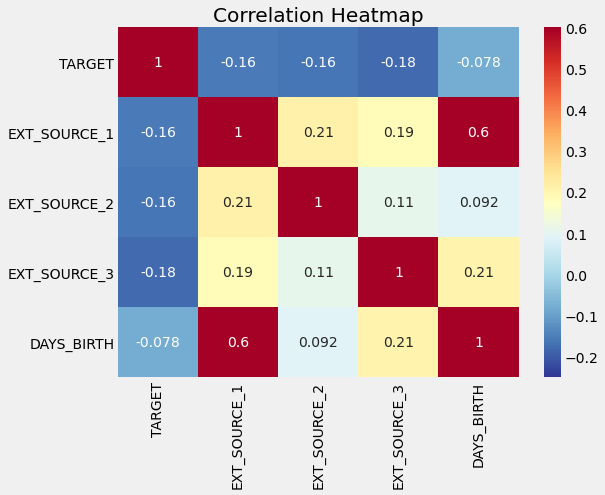

In [52]:
plt.figure(figsize=(8,6))
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

모든 EXT_SOURCE 변수가 target과 음의 상관관계를 갖는다. EXT_SOURCE 값이 증가할수록 고객이 대출금을 상환할 가능성이 높다는 것을 나타낸다. DAYS_BIRTH가 EXT_SOURCE_1과 양의 상관관계를 보이므로 이 점수의 요인 중 하나가 고객의 연령이라는 것을 알 수 있다.

이제 target값에 따라 색이 설정된 세 변수의 분포를 알아보자. 

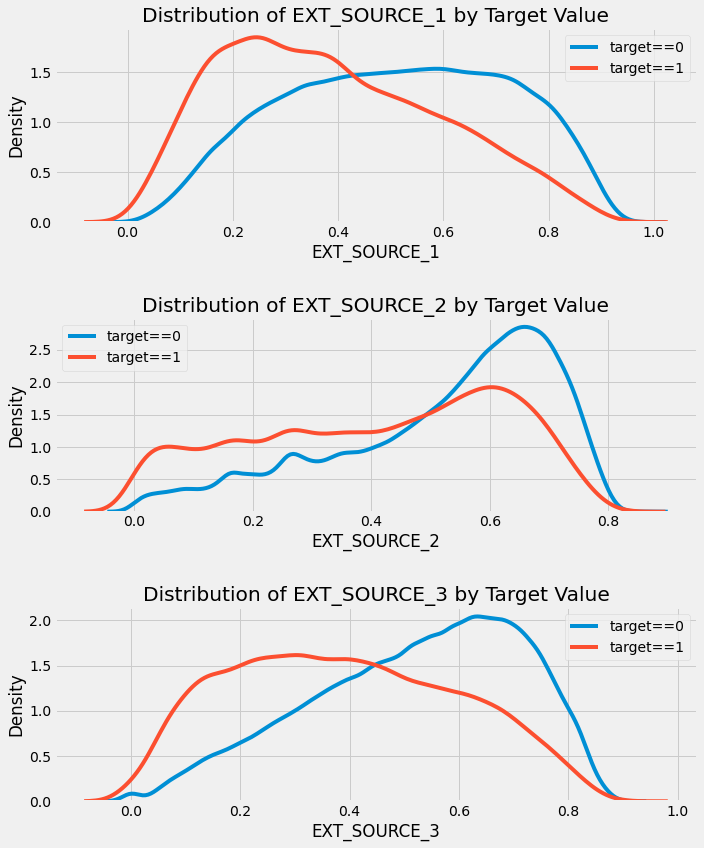

In [55]:
plt.figure(figsize=(10,12))

for i,source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']) :
    plt.subplot(3,1,i+1)
    # 상환된 대출금
    sns.kdeplot(app_train.loc[app_train['TARGET']==0, source], label='target==0')
    # 상환되지 않은 대출금
    sns.kdeplot(app_train.loc[app_train['TARGET']==1, source], label='target==1')
    
    plt.title('Distribution of %s by Target Value' %source)
    plt.xlabel('%s' %source)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad=2.5)

EXT_SOURCE_3은 target값과 차이가 가장 많이 난다. 이 변수가 신청자가 대출금을 상환할 가능성과 관계가 있다는 것을 알 수 있다. 관계는 강하지 않지만(사실 매우 약함), 상환 여부를 예측하는 기계학습 모델에 유용할 것이다.

## Pairs Plot

EDA의 최종 plot으로, EXT_SOURCE 변수와 DAYS_BIRTH 변수의 pairplot을 그려보자. pairplot은 단일 변수의 분포뿐만 아니라 여러 변수쌍간 관계를 볼 수 있기 때문에 좋은 탐색 도구다. seaborn 시각화 라이브러리와 PairGrid 함수를 사용해 위쪽 삼각존에 scatterplot을, 대각선에 히스토그램을, 아래쪽 삼각에 2D 커널밀도그래프와 상관계수를 생성한다.

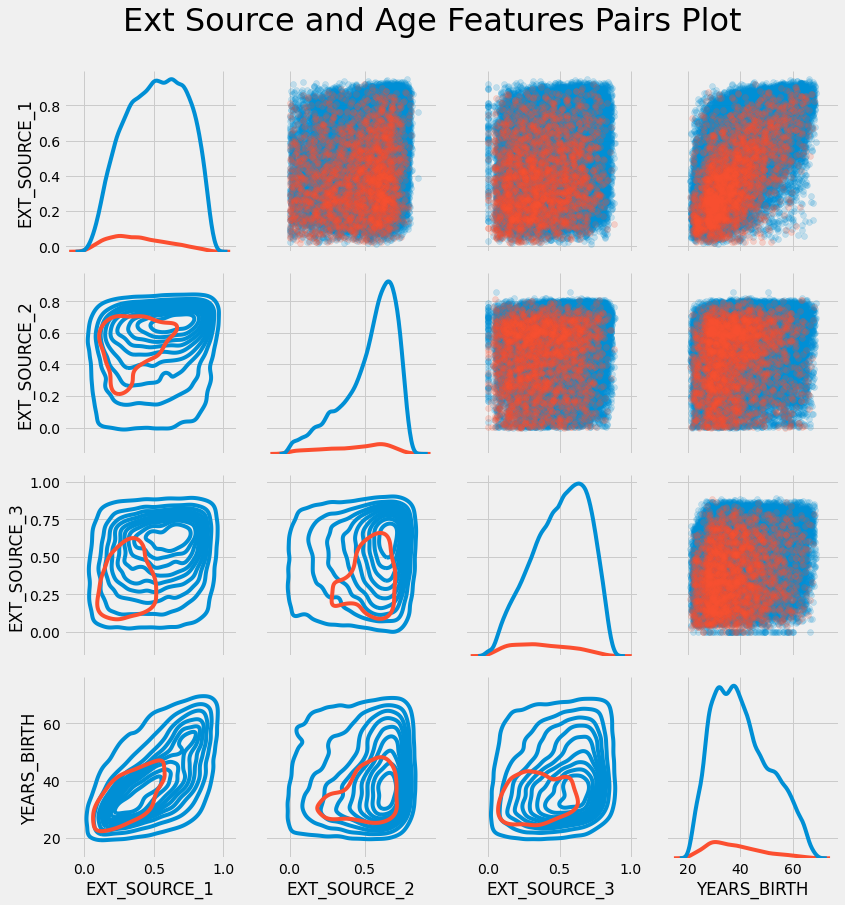

In [58]:
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()  # 시각화 위해 데이터 복사
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']  # 고객 연령을 연도로 추가
plot_data = plot_data.dropna().loc[:100000,:]  # na값 삭제 및 100000행까지 제한

# 두 열의 상관계수 계산하는 함수
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x,y)[0][1]
    ax = plt.gca()
    ax.annotate('r={:.2f}'.format(r), xy=(.2,.8), xycoords=ax.transAxes, size=20)
    
grid = sns.PairGrid(data=plot_data, size=3, diag_sharey=False, hue='TARGET',
                   vars=[x for x in list(plot_data.columns) if x!='TARGET'])
grid.map_upper(plt.scatter, alpha=0.2)  # 위에 scatterplot 
grid.map_diag(sns.kdeplot)  # 대각선에 kdeplot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)  # 아래 밀도그래프

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

붉은색은 상환되지 않은 대출금, 파란색은 상환된 대출금을 나타낸다. EXT_SOURCE_1과 DAYS_BIRTH(또는 동등한 YEARS_BIRTH)간 양의 선형관계가 나타나므로, 이 변수가 고객의 나이를 고려한다는 것을 나타낸다.

# Feature Engineering

feature engineering은 매우 중요하다. 올바른 모델과 최적의 설정도 중요하지만, 모델은 주어진 데이터만 학습할 수 있다. feature engineering은 일반적인 프로세스고 기존 데이터에서 새로운 변수 추가와 변수 선택을 포함한다. 가장 중요한 변수만 선택하거나 차원 축소 방법을 사용할 수 있다. 

두 가지 간단한 변수 구성 방법을 시도해보자.
- Polynomial features (다항식 변수)
- Domain knowledge features (도메인 지식 변수)

## Polynomial Features

Polynomial Features는 기존 변수간 상호작용뿐만 아니라 기존 변수의 힘을 나타내는 변수를 만든다. 예를 들어, EXT_SOURCE_1^2나 EXT_SOURCE_1*EXT_SOURCE_2와 같은 변수를 생성할 수 있다. 여러 변수의 조합인 이런 변수는 변수간 상호작용을 나타내기 때문에 교호작용 항이라고 한다. 다시 말해, 두 변수 자체는 target에 영향력이 강하지 않지만 교호작용 변수로 결합하면 target과의 관계를 볼 수 있다. 교호작용 항은 통계 모델에서 여러 변수의 효과를 포착하기 위해 흔히 사용되지만, 기계학습에는 자주 사용되지 않는 것 같다. 그럼에도, 우리 모델에 대출금 상환 여부를 예측하는 데 도움이 되는지 알아보기 위해 몇 가지 시험해보자.

다음 코드에서 EXT_SOURCE와 DAYS_BIRTH 변수를 사용해 polynomial feature를 생성해보자. scikit-learn은 polynomial과 교호작용 항을 지정된 degree까지 생성하는 PolynomialFeatures라는 유용한 클래스가 있다. degree=3으로 결과를 보자(polynomial feature를 생성할 때, 변수의 수가 degree에 따라 기하급수적으로 늘어나고, 과적합 문제가 발생할 수 있어 너무 높은 degree는 피한다).

In [61]:
# 새로운 데이터프레임 생성
poly_features = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns=['TARGET'])

# 결측값 처리 위한 imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# 결측값 대체
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=3)

In [62]:
# polynomial features 학습
poly_transformer.fit(poly_features)  

# features transform
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape :', poly_features.shape)

Polynomial Features shape : (307511, 35)


상당한 수의 새로운 변수를 생성했다. get_feature_names 메소드를 사용해 polynomial feature에 이름을 지어준다.

In [63]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

최대 3차까지 생성된 개별 변수와 교호작용 항을 가진 35개의 변수가 있다. 새로운 변수들이 target과 상관관계가 있는지 확인해보자.

In [67]:
# 새로운 데이터프레임 생성
poly_features = pd.DataFrame(poly_features, columns=poly_transformer.get_feature_names(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))

# target 추가
poly_features['TARGET'] = poly_target

# target과 상관관계
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))  # 음의 상관관계
print('--------------------')
print(poly_corrs.tail(5))  # 양의 상관관계

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
--------------------
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


일부 새로운 변수는 기존 변수보다 target과 상관관계가 더 크다(절대적 크기 측면에서). 기계학습 모델을 구축할 때 모델이 학습하는 데 실제로 도움이 되는지 이러한 변수를 사용하거나 사용하지 않음으로 확인해볼 수 있다.

이런 변수를 train, test 데이터 사본에 추가해 변수가 있는 모델과 없는 모델을 평가할 것이다. 

In [69]:
# test 변수에 데이터프레임 추가
poly_features_test = pd.DataFrame(poly_features_test, columns=poly_transformer.get_feature_names(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))

# train,test 데이터프레임에 polynomial 변수 병합
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

# 데이터프레임 inner join
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

print('Training data with polynomial features shape :', app_train_poly.shape)
print('Testing data with polynomial features shape :', app_test_poly.shape)

Training data with polynomial features shape : (307511, 275)
Testing data with polynomial features shape : (48744, 275)


## Domain Knowlege Features

신용 전문가가 아니므로 도메인 지식이라고 부르는 것이 옳지 않을 수도 있지만, "제한적인 금융 지식을 적용하려는 시도"로 볼 수 있다. 이 관점에서 고객의 채무불이행 여부를 확인하는 데 중요하다고 생각하는 것을 포착하기 위해 몇 가지 변수를 만들 수 있다. 여기선 5개의 변수를 사용할 것이다.
- CREDIT_INCOME_PERCENT : 고객 소득 대비 신용 금액 비율
- ANNUITYY_INCOME_PERCENT : 고객 소득 대비 대출연금 비율
- CREDIT_TERM : 지불 기간(월) (연금이 매월 지불해야하는 금액이므로)
- DAYS_EMPLOYED_PERCENT : 고객 연령 대비 고용일수 비율

In [71]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [72]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

### Visualize New Variables

domain knowledge 변수를 시각화한다. TARGET값으로 색이 지정된 같은 KDE plot을 만든다.

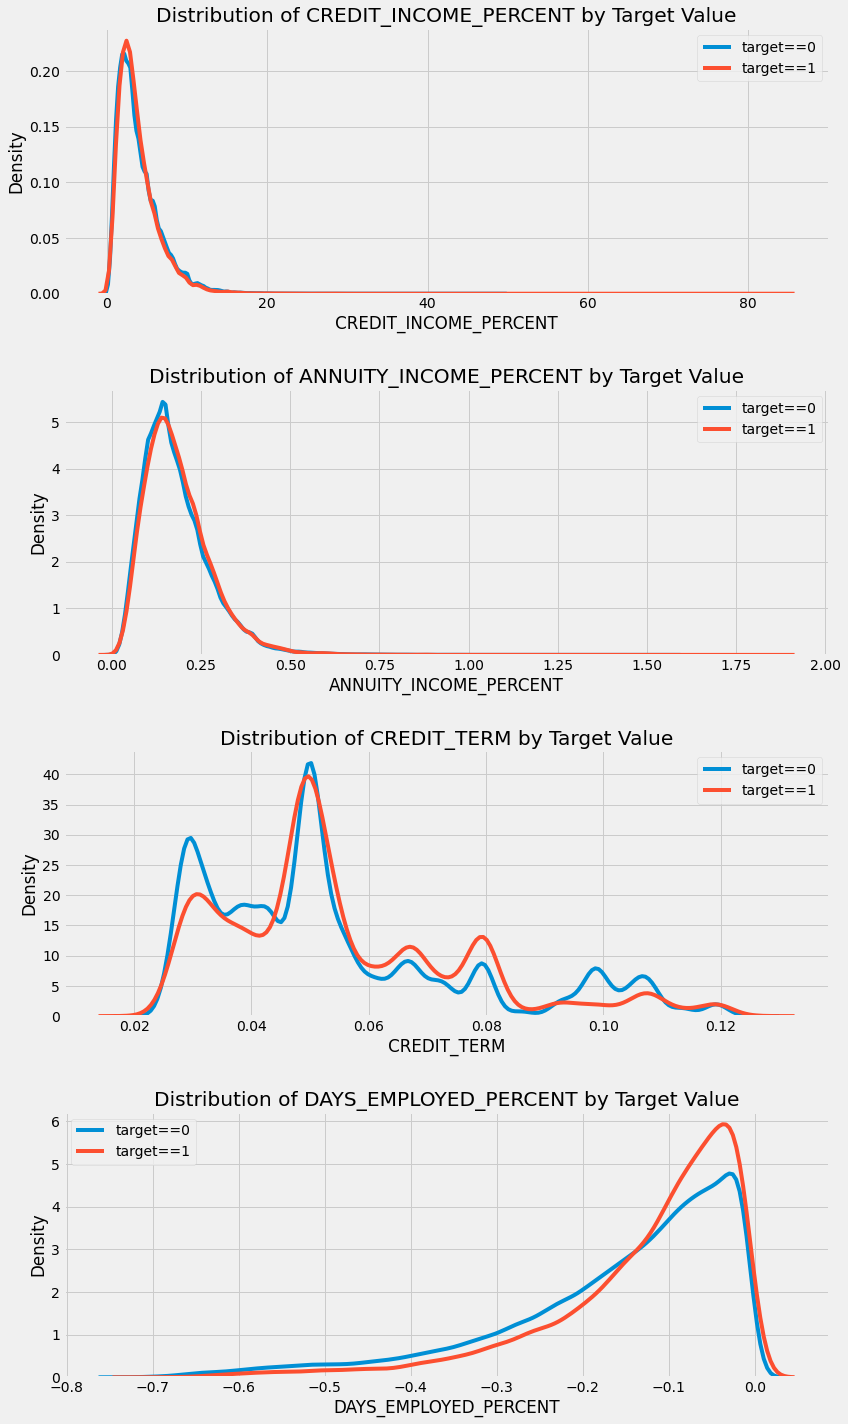

In [74]:
plt.figure(figsize=(12,20))

for i,feature in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4,1,i+1)
    
    # 상환된 대출금
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==0,feature],label='target==0')
    # 상환되지 않은 대출금
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==1,feature],label='target==1')
    
    plt.title('Distribution of %s by Target Value' %feature)
    plt.xlabel('%s' %feature)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

이런 새 변수들이 유용할지 미리 알기 어렵다. 확실히 아는 방법은 그것들을 시도해보는 것이다.

# Baseline

단순한 baseline에서 test 데이터셋의 모든 예시에 대해 동일한 값을 예측할 수 있다. 대출금을 상환하지 않을 확률을 예측하기 위해, 확실하지 않다면 test 데이터셋의 모든 관측치에 대해 0.5를 예측할 수 있다. 이를 통해 0.5의 AUC ROC를 얻을 수 있다. (분류작업에 대한 무작위 예측은 0.5점을 얻을 것이다)

어떤 점수를 받을지 이미 알고있으므로 naive baseline 추측을 할 필요가 없다. 실제 baseline에서 더 정교한 모델인 Logistic Regression을 사용해보자.

## Logistic Regression Implementation

baseline을 얻기 위해 범주형 변수를 인코딩한 후 모든 변수를 사용한다. 결측값을 채우고(imputation) 변수 범위를 정규화(feature scaling)하여 데이터를 전처리한다. 다음 코드는 그 두 가지 전처리를 수행한다.

In [76]:
from sklearn.preprocessing import MinMaxScaler

# train 데이터에서 target 제거
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)  # 변수 이름
test = app_test.copy() 

imputer = SimpleImputer(strategy='median')  # 결측값을 중위수로 대체
scaler = MinMaxScaler(feature_range=(0,1))  # 0-1로 각 변수 스케일
imputer.fit(train)  # train 데이터 fit

train = imputer.transform(train)
test = imputer.transform(app_test)

# scaler에 대해 반복
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape :', train.shape)
print('Testing data shape :', test.shape)

Training data shape : (307511, 240)
Testing data shape : (48744, 240)


첫 모델로 Scikit-Learn의 LogisticRegression을 사용한다. 기본 모델 설정에서 유일하게 변경할 것은 과적합 정도를 제어하는 정규화 매개변수 C를 낮추는 것이다(값 낮을수록 과적합 감소). 이렇게 해서 기본 로지스틱회귀보다 조금 더 나은 결과를 얻을 수 있지만, 향후 모든 모델에서 낮은 bar를 설정할 수 있을 것이다.

Scikit-Learn의 모델링 구문으로, 모델을 생성하고 .fit을 통해 모델을 학습시킨 후 .predit_proba를 사용해 test 데이터를 예측한다.

In [77]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.0001)  # 지정된 정규화 파라미터로 모델 생성
log_reg.fit(train, train_labels)  # train 데이터 학습

LogisticRegression(C=0.0001)

모델을 학습시켰으니 예측해야한다. .predict_proba 메소드를 사용하는데, m(관측치수)*2 배열을 반환한다. 첫 열은 target이 0일 확률이고 두번째 열은 target이 1일 확률이다(따라서 단일 행이면 두 열의 합이 1이어야함). 대출금이 상환되지 않는 확률을 예측해야하므로 두번째 열을 선택한다.

In [78]:
log_reg_pred = log_reg.predict_proba(test)[:,1]  # 예측 및 두번째 열만 선택

예측은 sample_submission.csv 파일에 표시된 형식이어야 하는데, SK_ID_CURR과 TARGET 두열만 있다. 이 test 데이터셋에서 이 형식의 데이터프레임을 만들고 submit 예측을 한다.

In [79]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078548
1,100005,0.137968
2,100013,0.082238
3,100028,0.080937
4,100038,0.132964


이런 예측은 대출금이 상환되지 않을 확률을 0과 1사이 확률로 나타낸다. 이런 예측을 통해 신청자를 분류하면, 대출금이 위험한지 판단하기 위한 확률 임계값을 설정할 수 있다.

In [81]:
submit.to_csv('log_reg_baseline.csv', index=False)

로지스틱회귀분석 baseline은 제출시 약 0.671점을 받는다.

## Improved Model : Random Forest

baseline의 낮은 성능을 해결하기 위해 알고리즘을 업데이트한다. 동일한 train 데이터에 랜덤포레스트를 사용해 성능에 어떤 영향을 미치는지 살펴보자. 랜덤포레스트는 수백개의 나무를 사용할 때 훨씬 강력하다. 랜덤포레스트에 100개의 나무를 사용해보자.

In [82]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1)

In [85]:
random_forest.fit(train, train_labels)  # train 데이터 학습

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature':features, 'importance':feature_importance_values})

predictions = random_forest.predict_proba(test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


In [86]:
# 제출 데이터프레임 생성
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# 제출 데이터프레임 저장
submit.to_csv('random_forest_baseline.csv', index=False)

이 모델은 제출시 약 0.678점을 받는다.